In [1]:
import os, random, math, time
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F

In [2]:
num_classes = 10

learning_rate = 0.008
num_epochs = 36
batch_size = 128

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [3]:
transform_ = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616)),
])

train_dataset = torchvision.datasets.CIFAR10(root='CIFAR10', train=True, download=True, transform=transform_)
test_dataset = torchvision.datasets.CIFAR10(root='CIFAR10', train=False, download=True, transform=transform_)

print(f"Train len: {len(train_dataset)}")
print(f"Test len: {len(test_dataset)}")

Train len: 50000
Test len: 10000


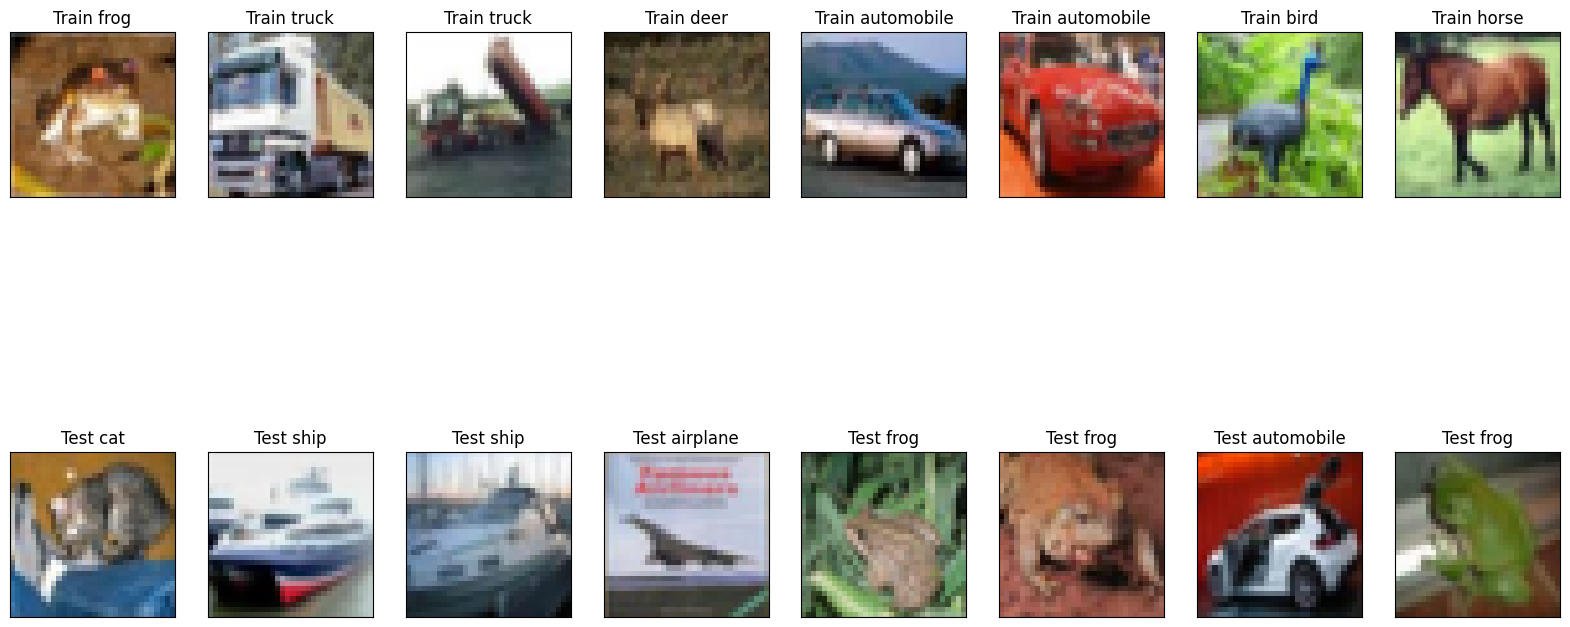

In [4]:
n_samples_show = 8
fig, axes = plt.subplots(nrows=2, ncols=n_samples_show, figsize=(20, 10))

for i in range(n_samples_show):
    axes[0][i].imshow(train_dataset.data[i])
    axes[0][i].set_xticks([])
    axes[0][i].set_yticks([])
    axes[0][i].set_title('Train {}'.format(train_dataset.classes[train_dataset.targets[i]]))
    axes[1][i].imshow(test_dataset.data[i])
    axes[1][i].set_xticks([])
    axes[1][i].set_yticks([])
    axes[1][i].set_title('Test {}'.format(test_dataset.classes[test_dataset.targets[i]]))

In [5]:
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)

In [6]:
class SEBlock(nn.Module):
    def __init__(self, channels, reduction=16):
        super(SEBlock, self).__init__()
        self.global_avgpool = nn.AdaptiveAvgPool2d(1)
        self.fc1 = nn.Linear(channels, channels // reduction)
        self.fc2 = nn.Linear(channels // reduction, channels)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        batch, channels, _, _ = x.size()
        y = self.global_avgpool(x).view(batch, channels)
        y = F.relu(self.fc1(y))
        y = self.sigmoid(self.fc2(y)).view(batch, channels, 1, 1)
        return x * y.expand_as(x)

class CIFAR10ModelSE(nn.Module):
    def __init__(self, num_classes=10):
        super(CIFAR10ModelSE, self).__init__()

        def conv_block(in_channels, out_channels, pool=False):
            layers = [
                nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True)
            ]
            if pool:
                layers.append(nn.MaxPool2d(2))
            return nn.Sequential(*layers)

        self.conv1 = conv_block(3, 64)
        self.conv2 = conv_block(64, 128, pool=True)
        self.se1 = SEBlock(128)

        self.conv3 = conv_block(128, 256)
        self.conv4 = conv_block(256, 512, pool=True)
        self.se2 = SEBlock(512)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(0.25)
        self.fc = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.se1(x)

        x = self.conv3(x)
        x = self.conv4(x)
        x = self.se2(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        x = self.fc(x)

        return x

In [7]:
model = CIFAR10ModelSE(num_classes)
model.to(device)
print(model)

CIFAR10ModelSE(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (se1): SEBlock(
    (global_avgpool): AdaptiveAvgPool2d(output_size=1)
    (fc1): Linear(in_features=128, out_features=8, bias=True)
    (fc2): Linear(in_features=8, out_features=128, bias=True)
    (sigmoid): Sigmoid()
  )
  (conv3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv4): Se

In [8]:
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
loss_fn = torch.nn.CrossEntropyLoss()

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=6, gamma=0.5)

In [9]:
def compute_accuracy(pred, target):
    pred_classes = pred.argmax(dim=1)
    accuracy = (pred_classes == target).float().mean()
    return accuracy.item()

def train_epoch(model, device, dataloader, loss_fn, optimizer):
    model.train()
    total_loss, total_accuracy = 0, 0

    for data, target in tqdm(dataloader, desc="Training"):
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        output = model(data)
        loss = loss_fn(output, target)
        loss.backward()
        optimizer.step()
  
        total_loss += loss.item()
        total_accuracy += compute_accuracy(output, target)

    return total_loss / len(dataloader), total_accuracy / len(dataloader)

def validate(model, device, dataloader, loss_fn):
    model.eval()
    total_loss, total_accuracy = 0, 0

    with torch.no_grad():
        for data, target in tqdm(dataloader, desc="Validation"):
            data, target = data.to(device), target.to(device)
            output = model(data)

            total_loss += loss_fn(output, target).item()
            total_accuracy += compute_accuracy(output, target)

    return total_loss / len(dataloader), total_accuracy / len(dataloader)

In [10]:
def train_model(model, trainloader, testloader, epochs, device, loss_fn, optimizer):
    train_loss_history = []
    train_acc_history = []
    test_acc_history = []
    test_loss_history = []

    for epoch in range(epochs):
        start_time = time.time()

        train_loss, train_accuracy = train_epoch(model, device, trainloader, loss_fn, optimizer)

        test_loss, test_accuracy = validate(model, device, testloader, loss_fn)

        scheduler.step()

        train_loss_history.append(train_loss)
        test_loss_history.append(test_loss)
        train_acc_history.append(train_accuracy)
        test_acc_history.append(test_accuracy)

        print(f"Эпоха {epoch}: Потери (train) = {train_loss:.4f}, "
              f"Потери (test) = {test_loss:.4f}, "
              f"Точность (train) = {train_accuracy:.4f}, "
              f"Точность (test) = {test_accuracy:.4f}, "
              f"Время = {time.time() - start_time:.4f}")

    return train_loss_history, test_loss_history, train_acc_history, test_acc_history

def test_model(model, testloader, device, loss_fn):
    start_time = time.time()

    _, test_accuracy = validate(model, device, testloader, loss_fn)

    print(f"Точность на тесте: {test_accuracy:.4f}")
    print(f"Время: {time.time() - start_time:.4f} секунд")

    return test_accuracy

Начальное тестирование


Validation: 100%|██████████| 79/79 [00:02<00:00, 36.44it/s]


Точность на тесте: 0.0989
Время: 2.1711 секунд

 Обучение на 36 эпохах


Validation: 100%|██████████| 79/79 [00:01<00:00, 40.33it/s]


Эпоха 0: Потери (train) = 1.4200, Потери (test) = 1.3043, Точность (train) = 0.4789, Точность (test) = 0.5279, Время = 23.0012


Validation: 100%|██████████| 79/79 [00:01<00:00, 41.69it/s]


Эпоха 1: Потери (train) = 0.9758, Потери (test) = 0.9598, Точность (train) = 0.6540, Точность (test) = 0.6667, Время = 22.8244


Validation: 100%|██████████| 79/79 [00:01<00:00, 40.55it/s]


Эпоха 2: Потери (train) = 0.7857, Потери (test) = 0.8300, Точность (train) = 0.7228, Точность (test) = 0.7023, Время = 22.1609


Validation: 100%|██████████| 79/79 [00:01<00:00, 42.56it/s]


Эпоха 3: Потери (train) = 0.6692, Потери (test) = 0.7443, Точность (train) = 0.7656, Точность (test) = 0.7411, Время = 21.8641


Validation: 100%|██████████| 79/79 [00:01<00:00, 40.18it/s]


Эпоха 4: Потери (train) = 0.5765, Потери (test) = 0.7464, Точность (train) = 0.7991, Точность (test) = 0.7399, Время = 22.1015


Validation: 100%|██████████| 79/79 [00:01<00:00, 40.51it/s]


Эпоха 5: Потери (train) = 0.5009, Потери (test) = 0.7880, Точность (train) = 0.8246, Точность (test) = 0.7395, Время = 22.8248


Validation: 100%|██████████| 79/79 [00:01<00:00, 40.44it/s]


Эпоха 6: Потери (train) = 0.3647, Потери (test) = 0.5108, Точность (train) = 0.8758, Точность (test) = 0.8281, Время = 22.8146


Validation: 100%|██████████| 79/79 [00:01<00:00, 40.31it/s]


Эпоха 7: Потери (train) = 0.3185, Потери (test) = 0.4938, Точность (train) = 0.8900, Точность (test) = 0.8317, Время = 22.6649


Validation: 100%|██████████| 79/79 [00:01<00:00, 40.08it/s]


Эпоха 8: Потери (train) = 0.2802, Потери (test) = 0.5623, Точность (train) = 0.9037, Точность (test) = 0.8130, Время = 22.8240


Validation: 100%|██████████| 79/79 [00:01<00:00, 39.67it/s]


Эпоха 9: Потери (train) = 0.2444, Потери (test) = 0.5092, Точность (train) = 0.9148, Точность (test) = 0.8361, Время = 23.0837


Validation: 100%|██████████| 79/79 [00:01<00:00, 40.02it/s]


Эпоха 10: Потери (train) = 0.2089, Потери (test) = 0.5414, Точность (train) = 0.9279, Точность (test) = 0.8252, Время = 22.9987


Validation: 100%|██████████| 79/79 [00:01<00:00, 39.59it/s]


Эпоха 11: Потери (train) = 0.1780, Потери (test) = 0.6700, Точность (train) = 0.9390, Точность (test) = 0.7984, Время = 22.7900


Validation: 100%|██████████| 79/79 [00:01<00:00, 40.03it/s]


Эпоха 12: Потери (train) = 0.1049, Потери (test) = 0.4841, Точность (train) = 0.9672, Точность (test) = 0.8554, Время = 22.7135


Validation: 100%|██████████| 79/79 [00:01<00:00, 39.85it/s]


Эпоха 13: Потери (train) = 0.0797, Потери (test) = 0.5237, Точность (train) = 0.9755, Точность (test) = 0.8515, Время = 22.7509


Validation: 100%|██████████| 79/79 [00:01<00:00, 39.50it/s]


Эпоха 14: Потери (train) = 0.0707, Потери (test) = 0.5441, Точность (train) = 0.9779, Точность (test) = 0.8496, Время = 22.8941


Validation: 100%|██████████| 79/79 [00:01<00:00, 39.74it/s]


Эпоха 15: Потери (train) = 0.0587, Потери (test) = 0.6617, Точность (train) = 0.9817, Точность (test) = 0.8353, Время = 22.8066


Validation: 100%|██████████| 79/79 [00:01<00:00, 39.78it/s]


Эпоха 16: Потери (train) = 0.0574, Потери (test) = 0.5720, Точность (train) = 0.9819, Точность (test) = 0.8494, Время = 22.7857


Validation: 100%|██████████| 79/79 [00:01<00:00, 39.91it/s]


Эпоха 17: Потери (train) = 0.0574, Потери (test) = 0.6291, Точность (train) = 0.9813, Точность (test) = 0.8389, Время = 22.7877


Validation: 100%|██████████| 79/79 [00:01<00:00, 39.61it/s]


Эпоха 18: Потери (train) = 0.0292, Потери (test) = 0.5664, Точность (train) = 0.9931, Точность (test) = 0.8594, Время = 22.7803


Validation: 100%|██████████| 79/79 [00:01<00:00, 39.85it/s]


Эпоха 19: Потери (train) = 0.0229, Потери (test) = 0.5630, Точность (train) = 0.9947, Точность (test) = 0.8608, Время = 22.7972


Validation: 100%|██████████| 79/79 [00:02<00:00, 39.34it/s]


Эпоха 20: Потери (train) = 0.0194, Потери (test) = 0.6190, Точность (train) = 0.9959, Точность (test) = 0.8573, Время = 22.8563


Validation: 100%|██████████| 79/79 [00:01<00:00, 39.60it/s]


Эпоха 21: Потери (train) = 0.0203, Потери (test) = 0.5890, Точность (train) = 0.9953, Точность (test) = 0.8607, Время = 22.6987


Validation: 100%|██████████| 79/79 [00:01<00:00, 40.30it/s]


Эпоха 22: Потери (train) = 0.0191, Потери (test) = 0.6134, Точность (train) = 0.9954, Точность (test) = 0.8608, Время = 22.7931


Validation: 100%|██████████| 79/79 [00:01<00:00, 39.88it/s]


Эпоха 23: Потери (train) = 0.0202, Потери (test) = 0.6517, Точность (train) = 0.9950, Точность (test) = 0.8499, Время = 22.7798


Validation: 100%|██████████| 79/79 [00:01<00:00, 39.83it/s]


Эпоха 24: Потери (train) = 0.0115, Потери (test) = 0.6054, Точность (train) = 0.9978, Точность (test) = 0.8620, Время = 22.7842


Validation: 100%|██████████| 79/79 [00:02<00:00, 39.16it/s]


Эпоха 25: Потери (train) = 0.0099, Потери (test) = 0.6192, Точность (train) = 0.9983, Точность (test) = 0.8622, Время = 22.9510


Validation: 100%|██████████| 79/79 [00:02<00:00, 38.68it/s]


Эпоха 26: Потери (train) = 0.0090, Потери (test) = 0.6111, Точность (train) = 0.9987, Точность (test) = 0.8631, Время = 22.9705


Validation: 100%|██████████| 79/79 [00:01<00:00, 40.13it/s]


Эпоха 27: Потери (train) = 0.0083, Потери (test) = 0.6425, Точность (train) = 0.9988, Точность (test) = 0.8620, Время = 23.0293


Validation: 100%|██████████| 79/79 [00:01<00:00, 40.87it/s]


Эпоха 28: Потери (train) = 0.0099, Потери (test) = 0.6536, Точность (train) = 0.9979, Точность (test) = 0.8608, Время = 22.5880


Validation: 100%|██████████| 79/79 [00:01<00:00, 40.44it/s]


Эпоха 29: Потери (train) = 0.0082, Потери (test) = 0.6579, Точность (train) = 0.9989, Точность (test) = 0.8617, Время = 22.4638


Validation: 100%|██████████| 79/79 [00:01<00:00, 41.43it/s]


Эпоха 30: Потери (train) = 0.0070, Потери (test) = 0.6384, Точность (train) = 0.9990, Точность (test) = 0.8649, Время = 22.3912


Validation: 100%|██████████| 79/79 [00:01<00:00, 41.13it/s]


Эпоха 31: Потери (train) = 0.0064, Потери (test) = 0.6427, Точность (train) = 0.9988, Точность (test) = 0.8633, Время = 22.3544


Validation: 100%|██████████| 79/79 [00:01<00:00, 41.25it/s]


Эпоха 32: Потери (train) = 0.0056, Потери (test) = 0.6420, Точность (train) = 0.9992, Точность (test) = 0.8648, Время = 22.3871


Validation: 100%|██████████| 79/79 [00:01<00:00, 41.51it/s]


Эпоха 33: Потери (train) = 0.0053, Потери (test) = 0.6561, Точность (train) = 0.9993, Точность (test) = 0.8629, Время = 22.3717


Validation: 100%|██████████| 79/79 [00:01<00:00, 40.73it/s]


Эпоха 34: Потери (train) = 0.0053, Потери (test) = 0.6596, Точность (train) = 0.9992, Точность (test) = 0.8634, Время = 22.3052


Validation: 100%|██████████| 79/79 [00:01<00:00, 41.68it/s]


Эпоха 35: Потери (train) = 0.0055, Потери (test) = 0.6645, Точность (train) = 0.9992, Точность (test) = 0.8632, Время = 22.3624

 Обучение заняло: 816.36 секунд

 Финальное тестирование


Validation: 100%|██████████| 79/79 [00:01<00:00, 41.50it/s]


Точность на тесте: 0.8632
Время: 1.9052 секунд

 Улучшение точности: 0.7643


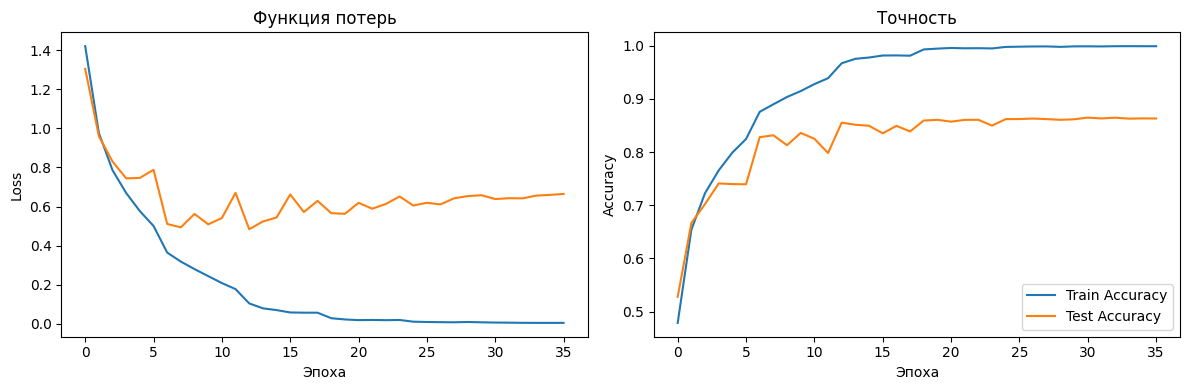

In [11]:
print("Начальное тестирование")
init_acc = test_model(model, testloader, device, loss_fn)

print(f"\n Обучение на {num_epochs} эпохах")
start_time = time.time()
train_loss, test_loss, train_acc, test_acc = train_model(
    model, trainloader, testloader, num_epochs, device, loss_fn, optimizer
)

print(f"\n Обучение заняло: {time.time() - start_time:.2f} секунд")

print("\n Финальное тестирование")
final_acc = test_model(model, testloader, device, loss_fn)

print(f"\n Улучшение точности: {final_acc - init_acc:.4f}")

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Train Loss')
plt.plot(test_loss, label='Test Loss')
plt.title('Функция потерь')
plt.xlabel('Эпоха')
plt.ylabel('Loss')

plt.subplot(1, 2, 2)
plt.plot(train_acc, label='Train Accuracy')
plt.plot(test_acc, label='Test Accuracy')
plt.title('Точность')
plt.xlabel('Эпоха')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


In [12]:
def detailed_test_analysis(model, device, dataloader, num_classes):
    model.eval()

    class_correct = [0] * num_classes
    class_total = [0] * num_classes
    all_predictions = []
    all_targets = []

    confusion_matrix = torch.zeros(num_classes, num_classes, dtype=torch.int64)

    with torch.no_grad():
        for data, target in tqdm(dataloader, desc="Detailed Testing"):
            data, target = data.to(device), target.to(device)
            output = model(data)
            _, predicted = torch.max(output, 1)

            all_predictions.extend(predicted.cpu().numpy())
            all_targets.extend(target.cpu().numpy())

            for t, p in zip(target.view(-1), predicted.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

            for i in range(len(target)):
                label = target[i]
                class_correct[label] += (predicted[i] == label).item()
                class_total[label] += 1

    print("\n" + "="*60)
    print("ДЕТАЛЬНЫЙ АНАЛИЗ ТЕСТИРОВАНИЯ")
    print("="*60)

    total_accuracy = sum(class_correct) / sum(class_total) if sum(class_total) > 0 else 0
    print(f"\nОбщая точность: {total_accuracy:.4f} ({sum(class_correct)}/{sum(class_total)})")

    print("\nТочность по классам:")
    print("-" * 50)

    class_accuracies = []
    class_details = {}
    for i in range(num_classes):
        if class_total[i] > 0:
            accuracy = class_correct[i] / class_total[i]
            class_accuracies.append(accuracy)
        else:
            accuracy = 0
            class_accuracies.append(0)

        class_name = dataloader.dataset.classes[i]
        class_details[class_name] = {
            'accuracy': float(accuracy),
            'correct': int(class_correct[i]),
            'total': int(class_total[i])
        }
        print(f"{i} - {class_name:20s}: {accuracy:.4f} ({class_correct[i]}/{class_total[i]})")

    mean_accuracy = np.mean(class_accuracies)
    median_accuracy = np.median(class_accuracies)
    max_accuracy = np.max(class_accuracies)
    min_accuracy = np.min(class_accuracies)
    std_accuracy = np.std(class_accuracies)

    print("\nСтатистика:")
    print("-" * 50)
    print(f"Средняя точность по классам: {mean_accuracy:.4f}")
    print(f"Медиана точности по классам: {median_accuracy:.4f}")
    print(f"Максимальная точность: {max_accuracy:.4f}")
    print(f"Минимальная точность: {min_accuracy:.4f}")
    print(f"Стандартное отклонение: {std_accuracy:.4f}")

    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    colors = ['green' if acc >= 0.7 else 'orange' if acc >= 0.5 else 'red' for acc in class_accuracies]
    bars = plt.bar(range(num_classes), class_accuracies, color=colors, alpha=0.7)
    plt.axhline(y=total_accuracy, color='red', linestyle='--', label=f'Общая точность: {total_accuracy:.3f}')
    plt.xlabel('Классы')
    plt.ylabel('Точность')
    plt.title('Точность по классам')
    plt.legend()
    plt.grid(True, alpha=0.3)

    for bar, acc in zip(bars, class_accuracies):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                f'{acc:.3f}', ha='center', va='bottom', fontsize=8)

    plt.subplot(1, 2, 2)
    confusion_np = confusion_matrix.numpy()

    with np.errstate(divide='ignore', invalid='ignore'):
        confusion_normalized = confusion_np.astype('float') / confusion_np.sum(axis=1)[:, np.newaxis]
        confusion_normalized = np.nan_to_num(confusion_normalized)

    im = plt.imshow(confusion_normalized, cmap='Blues', interpolation='nearest')
    plt.colorbar(im, fraction=0.046, pad=0.04)
    plt.title('Нормализованная матрица ошибок')
    plt.xlabel('Предсказанный класс')
    plt.ylabel('Истинный класс')

    thresh = confusion_normalized.max() / 2.
    for i in range(num_classes):
        for j in range(num_classes):
            plt.text(j, i, f'{confusion_np[i, j]}\n({confusion_normalized[i, j]:.2f})',
                    ha="center", va="center",
                    color="white" if confusion_normalized[i, j] > thresh else "black",
                    fontsize=8)

    plt.tight_layout()
    plt.plot()

    results = {
        'total_accuracy': float(total_accuracy),
        'total_correct': int(sum(class_correct)),
        'total_samples': int(sum(class_total)),
        'class_total': class_total,
        'class_details': class_details,
        'statistics': {
            'mean_accuracy': float(mean_accuracy),
            'median_accuracy': float(median_accuracy),
            'max_accuracy': float(max_accuracy),
            'min_accuracy': float(min_accuracy),
            'std_accuracy': float(std_accuracy)
        },
        'confusion_matrix': confusion_matrix.tolist(),
    }

    return results

Detailed Testing: 100%|██████████| 79/79 [00:03<00:00, 23.69it/s]



ДЕТАЛЬНЫЙ АНАЛИЗ ТЕСТИРОВАНИЯ

Общая точность: 0.8638 (8638/10000)

Точность по классам:
--------------------------------------------------
0 - airplane            : 0.8870 (887/1000)
1 - automobile          : 0.9330 (933/1000)
2 - bird                : 0.7960 (796/1000)
3 - cat                 : 0.7500 (750/1000)
4 - deer                : 0.8610 (861/1000)
5 - dog                 : 0.7710 (771/1000)
6 - frog                : 0.8950 (895/1000)
7 - horse               : 0.9060 (906/1000)
8 - ship                : 0.9180 (918/1000)
9 - truck               : 0.9210 (921/1000)

Статистика:
--------------------------------------------------
Средняя точность по классам: 0.8638
Медиана точности по классам: 0.8910
Максимальная точность: 0.9330
Минимальная точность: 0.7500
Стандартное отклонение: 0.0636


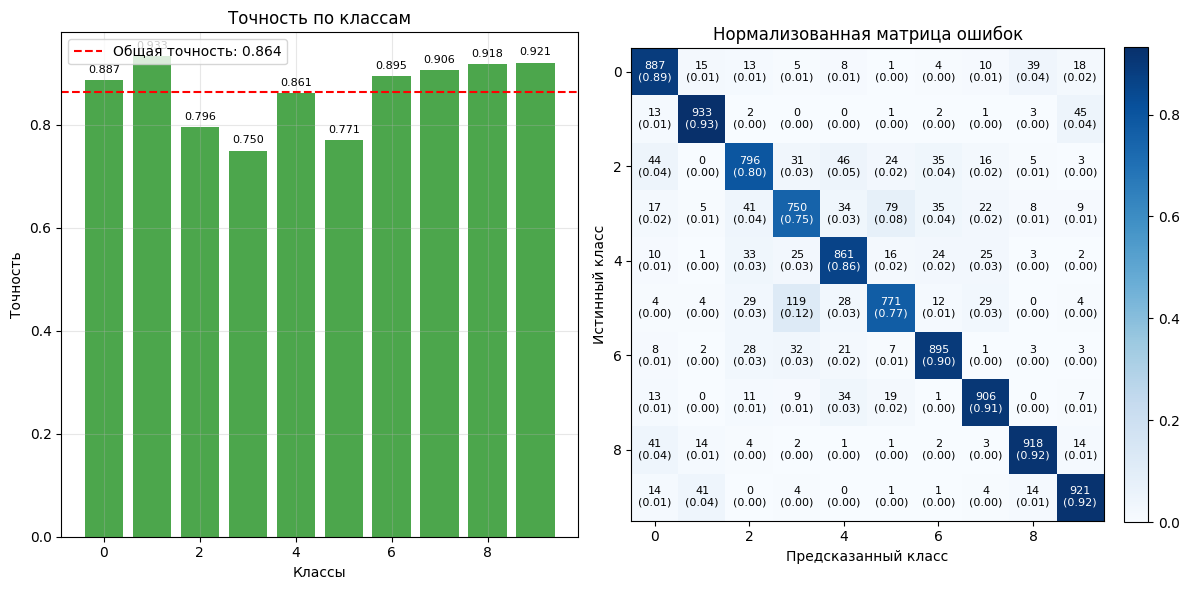

In [13]:
_ = detailed_test_analysis(model, device, testloader, num_classes)